In [2]:
%matplotlib notebook
%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = "cntk" # you can use "cntk" or "tensorflow"
import time
import datetime as dt
import numpy as np
from numpy import newaxis
from numpy import array
import matplotlib.pyplot as plt
import pandas
from urllib.request import urlretrieve
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using CNTK backend


# Load Microsoft (MSFT) stock data from Quandl

In [3]:
start_date = "2005-01-01"
end_date =   "2017-10-01"
stock = "MSFT"
order = "asc"
parameters = '?&start_date='+start_date+'&end_date='+end_date+'&order='+order
file = stock+".csv"

def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + url )
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File is already on disk')

# Download  dataset.
download('https://www.quandl.com/api/v3/datasets/WIKI/' + stock + '.csv' + parameters, file)

File is already on disk


In [4]:
data = pandas.read_csv(file, index_col='Date')
# Converting the index as date
data.index = pandas.to_datetime(data.index)

In [5]:
data.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,3209.000000,3209.000000,3209.000000,3209.000000,3.209000e+03,3209.000000,3209.0,3209.000000,3209.000000,3209.000000,3209.000000,3.209000e+03
mean,34.766518,35.083899,34.459177,34.781746,5.335675e+07,0.003175,1.0,30.591459,30.867297,30.323665,30.605503,5.335675e+07
std,12.956947,13.014674,12.893192,12.969427,3.064675e+07,0.028138,0.0,14.343574,14.418980,14.262729,14.356119,3.064675e+07
min,15.200000,15.620000,14.870000,15.150000,8.409616e+06,0.000000,1.0,12.216221,12.553775,11.951001,12.176036,8.409616e+06
25%,26.140000,26.400000,25.880000,26.150000,3.333800e+07,0.000000,1.0,20.940801,21.158354,20.745410,20.943368,3.333800e+07
50%,29.320000,29.600000,29.040000,29.340000,4.845660e+07,0.000000,1.0,23.879344,24.070798,23.660965,23.867928,4.845660e+07
75%,41.630000,41.990000,41.330100,41.685000,6.502900e+07,0.000000,1.0,38.675557,39.050866,38.357853,38.725882,6.502900e+07
max,75.350000,75.970000,75.040000,75.440000,5.910522e+08,0.390000,1.0,75.350000,75.970000,75.040000,75.440000,5.910522e+08


In [6]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2005-01-03,26.80,26.95,26.6490,26.74,65002900.0,0.0,1.0,20.181438,20.294394,20.067729,20.136256,65002900.0
2005-01-04,26.86,27.10,26.6600,26.84,109442100.0,0.0,1.0,20.226620,20.407349,20.076012,20.211559,109442100.0
2005-01-05,26.84,27.10,26.7600,26.78,72463500.0,0.0,1.0,20.211559,20.407349,20.151316,20.166377,72463500.0
2005-01-06,26.86,27.06,26.6399,26.75,76890500.0,0.0,1.0,20.226620,20.377228,20.060876,20.143786,76890500.0
2005-01-07,26.83,26.89,26.6200,26.67,68723300.0,0.0,1.0,20.204029,20.249211,20.045891,20.083543,68723300.0


# Data Normalization and Columns pick

In [7]:
#normalise data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
cols = ['Open','High','Low','Volume','Close']
#cols = ['Adj. Open','Adj. High','Adj. Low','Adj. Volume','Adj. Close']
df = pandas.DataFrame(scaler.fit_transform(data[cols]) , columns=cols, index=data.index, dtype="float32") #Normalize
df.head()

,Open,High,Low,Volume,Close
Date,,,,,
2005-01-03,0.192851,0.187738,0.195762,0.097132,0.192238
2005-01-04,0.193849,0.190224,0.195945,0.173404,0.193896
2005-01-05,0.193516,0.190224,0.197607,0.109937,0.192901
2005-01-06,0.193849,0.189561,0.195611,0.117535,0.192403
2005-01-07,0.193350,0.186744,0.195280,0.103517,0.191076


In [8]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #converts to numpy
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [9]:
def build_model(moving_window, num_features):
        d = 0.2
        model = Sequential()
        model.add(LSTM(64, input_shape=(moving_window, num_features), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, kernel_initializer="uniform", activation="relu"))
        model.add(Dense(1, kernel_initializer="uniform",activation='relu'))
        model.compile(loss='mse', optimizer='adam', metrics=['mape'])
        return model

In [10]:
window = 10
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2878, 10, 5)
y_train (2878,)
X_test (320, 10, 5)
y_test (320,)


In [11]:
model = build_model(window,len(X_train[0][0]))

In [12]:
%%time
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=1000,
    validation_split=0.1,
    verbose=0)

CPU times: user 1min 1s, sys: 3.81 s, total: 1min 5s
Wall time: 1min 4s


In [13]:
import math

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00007 MSE (0.00860 RMSE)
Test Score: 0.00002 MSE (0.00395 RMSE)


In [14]:
# print(X_test[-1])
yhat = model.predict(X_test)

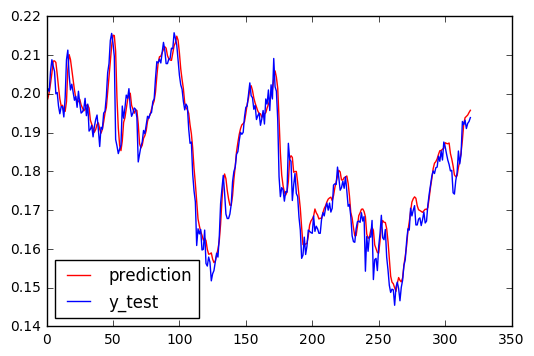

In [15]:
plt.plot(yhat,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='lower left')
plt.show()

# So, where to go from here?

Well, as you can imagine, this is a simple MANY-TO-ONE prediction. The model is predicting the next Time Step by getting as input a window (sequence) of past measures.
This model can be improved by:
    1. Making the series stationary and using StandardScaler vs MaxMinScaler
    2. Predicting the next N steps (multi-step prediction) by using seq2seq models vs a simple RNN (like above)
    3. And the most important of all: Adding more signals/features/columns
